In [6]:
# Importar paquetes necesarios
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [7]:
def test_function(name_funcion: str, valor: list) -> np.array:
    x, y = valor

    match name_funcion:
        case "esfera":
            return np.array(x**2 + y**2)
        case "rastrigin":
            return (
                20
                + x**2
                - 10 * np.cos(2 * np.pi * x)
                + y**2
                - 10 * np.cos(2 * np.pi * y)
            )
        case "rosenbrock":
            return (y - x**2) ** 2 + (1 - x) ** 2
        case "booth":
            return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2
        case "matyas":
            return 0.26 * (x**2 + y**2) - 0.48 * x * y
        case _:
            print(ValueError(f"_{name_funcion}_ No se encuentra implementada"))

In [8]:
class AG:
    def __init__(
        self,
        function: list,
        name: str,
        n_bits: int = 16,
        n_iter: int = 100,
        n_pop: int = 100,
        r_cross: float = 0.9,
        r_mut: float = 0.1,
    ):
        """Algoritmo Genetico para minimizacion

        Args:
            function (list): array de la funcion objetivo bidimensional (x,y)
            name (str): nombre de la funcion ovjetivo
            n_bits (int): numero de bits por solucion
            n_iter (int): maximo de generaciones
            n_pop (int): tamano de la poblacion
            r_cross (float): tasa de cruce [0.5,1]
            r_mut (float): tasa de mutacion [0,0.4]
        """
        self.function = function
        self.name = name
        self.n_bits = n_bits
        self.n_iter = n_iter
        self.n_pop = n_pop
        self.r_cross = r_cross
        self.r_mut = r_mut  # / (float(self.n_bits) * 2)
        self.bounds = [[-5.12, 5.12], [-5.12, 5.12]]
        self.minimizers = []
        self.minimuns = []

    def decode(self, bitstring):
        # decodificar cadena de bits a números
        decoded = []
        largest = 2**self.n_bits
        for i in range(len(self.bounds)):
            # extraer la subcadena
            start, end = i * self.n_bits, (i * self.n_bits) + self.n_bits
            substring = bitstring[start:end]
            # convertir una cadena de bits en una cadena de caracteres
            chars = "".join([str(s) for s in substring])
            # convertir cadena a entero
            integer = int(chars, 2)
            # escalar el número entero al rango deseado
            value = self.bounds[i][0] + (integer / largest) * (
                self.bounds[i][1] - self.bounds[i][0]
            )
            decoded.append(value)
        return decoded

    def selection(self, pop, scores, k=3):
        # selección por torneo - primera selección aleatoria
        selection_ix = rn.randint(len(pop))
        for ix in rn.randint(0, len(pop), k - 1):
            # comprobar si es mejor (realizar un torneo)
            if scores[ix] < scores[selection_ix]:
                selection_ix = ix
        return pop[selection_ix]

    def crossover(self, p1, p2):
        # cruzar dos padres para crear dos hijos
        c1, c2 = p1.copy(), p2.copy()
        if rn.rand() < self.r_cross:
            pt = rn.randint(1, len(p1) - 2)
            c1 = p1[:pt] + p2[pt:]
            c2 = p2[:pt] + p1[pt:]
        return [c1, c2]

    def mutation(self, bitstring):
        # operador de mutación bit a bit
        for i in range(len(bitstring)):
            if rn.rand() < self.r_mut:
                # voltear el bit
                bitstring[i] = 1 - bitstring[i]

    def genetic_algorithm(self):
        # algoritmo genético
        # población inicial de cadena de bits aleatoria
        pop = [
            rn.randint(0, 2, self.n_bits * len(self.bounds)).tolist()
            for _ in range(self.n_pop)
        ]
        best, best_eval = 0, self.function(self.name, self.decode(pop[0]))
        for gen in range(self.n_iter):
            decoded = [self.decode(p) for p in pop]
            scores = [self.function(self.name, d) for d in decoded]
            for i in range(self.n_pop):
                if scores[i] < best_eval:
                    best, best_eval = pop[i], scores[i]
                    self.minimizers.append(decoded[i])
                    self.minimuns.append(scores[i])
                    # print(">%d, new best f(%s) = %f" % (gen, decoded[i], scores[i]))
            selected = [self.selection(pop, scores) for _ in range(self.n_pop)]
            # crear la próxima generación
            children = list()
            for i in range(0, self.n_pop, 2):
                # conseguir padres seleccionados en parejas
                p1, p2 = selected[i], selected[i + 1]
                # cruce y mutación
                for c in self.crossover(p1, p2):
                    self.mutation(c)
                    children.append(c)
            # reemplazar población
            pop = children
        return [best, best_eval]

In [9]:
np.random.seed(6)
name = "matyas"
# define the total iterations
n_iter = 100
# bits per variable
n_bits = 16
# define the population size
n_pop = 100
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 0.005
ag = AG(test_function, name, n_bits, n_iter, n_pop, r_cross, r_mut)
best, score = ag.genetic_algorithm()
print("Minimo encontrado")
decoded = ag.decode(best)
print("f(%s) = %f" % (decoded, score))

Minimo encontrado
f([0.08671875000000018, 0.07781250000000028]) = 0.000291


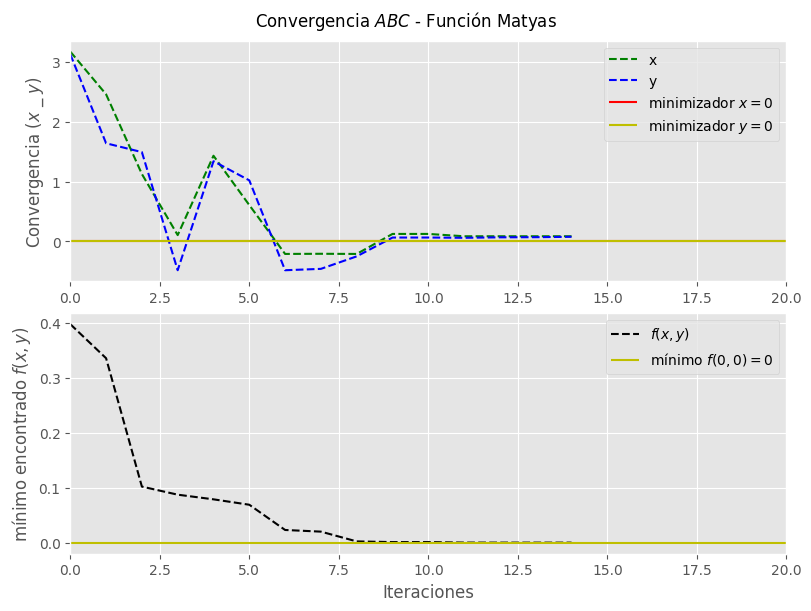

In [10]:
plt.style.use("ggplot")
xmax = 20
fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained", figsize=(8, 6))
fig.suptitle(rf"Convergencia $ABC$ - Función {name.capitalize()}")
ax1.plot([p[0] for p in ag.minimizers], "g--", label="x")
ax1.plot([p[1] for p in ag.minimizers], "b--", label="y")
ax1.hlines(y=0, xmin=0, xmax=xmax, colors="r", label=r"minimizador $x=0$")
ax1.hlines(y=0, xmin=0, xmax=xmax, colors="y", label=r"minimizador $y=0$")
ax1.set_ylabel(r"Convergencia $(x$ _ $y)$")
ax1.legend()
ax1.grid(True)
ax2.plot(ag.minimuns, "k--", label=r"$f(x,y)$")
ax2.hlines(y=0, xmin=0, xmax=xmax, colors="y", label="mínimo $f(0,0)=0$")
ax2.set_ylabel(r"mínimo encontrado $f(x,y)$")
ax2.set_xlabel("Iteraciones")
ax1.set_xlim(0, xmax)
ax2.set_xlim(0, xmax)
ax2.grid(True)
ax2.legend()
plt.show()

In [11]:
def contorno(name_function, xm, ym):
    plt.style.use("ggplot")
    v = np.linspace(-5.12, 5.12, 100)
    X, Y = np.meshgrid(v, v)
    Z = test_function(name_function, [X, Y])
    fig, ax = plt.subplots(figsize=(6, 6))
    cmp = cm.inferno
    ax.contourf(v, v, Z, 50, cmap=cmp, alpha=0.8, antialiased=True)
    ax.plot(xm, ym, "y*--", markersize=15)
    ax.set_title(
        rf"""Function test ${name_function.capitalize()}$
        Mínimo Global $f(0,0) = 0$"""
    )
    ax.set_xlabel(r"x")
    ax.set_ylabel(r"y")
    plt.show()

15 -0.2084374999999996 3.17078125
15 -0.48062499999999986 3.1262499999999998


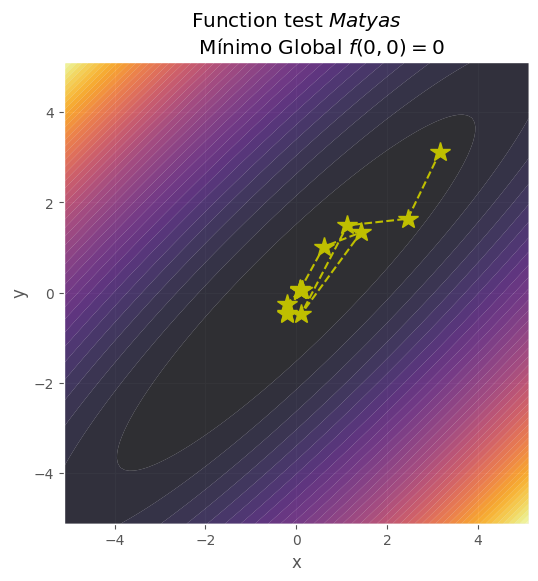

In [12]:
x = [mx[0] for mx in ag.minimizers]
print(len(x), min(x), max(x))
y = [mx[1] for mx in ag.minimizers]
print(len(x), min(y), max(y))

contorno(name, x, y)

In [13]:
"""
np.random.seed(6)
iteraciones = 21
minimos_values = []
print(f"{iteraciones} iteraciones", "->", "minimizador (x,y)", "->", "mínimo f(x,y)")

for _ in range(iteraciones):
    ag = AG(test_function, name, n_bits, n_iter, n_pop, r_cross, r_mut)
    best, score = ag.genetic_algorithm()
    minimos_values.append(score)
    print(f"{ag.decode(best)} = {score}")

print("     ")
print("Promedio de mínimos:", np.mean(minimos_values))
print("mediana de mínimos:", np.median(minimos_values))
print("desviación STD de mínimos:", np.std(minimos_values))
print("valor mínimo:", np.min(minimos_values))
print("valor máximo:", np.max(minimos_values))
"""

'\nnp.random.seed(6)\niteraciones = 21\nminimos_values = []\nprint(f"{iteraciones} iteraciones", "->", "minimizador (x,y)", "->", "mínimo f(x,y)")\n\nfor _ in range(iteraciones):\n    ag = AG(test_function, name, n_bits, n_iter, n_pop, r_cross, r_mut)\n    best, score = ag.genetic_algorithm()\n    minimos_values.append(score)\n    print(f"{ag.decode(best)} = {score}")\n\nprint("     ")\nprint("Promedio de mínimos:", np.mean(minimos_values))\nprint("mediana de mínimos:", np.median(minimos_values))\nprint("desviación STD de mínimos:", np.std(minimos_values))\nprint("valor mínimo:", np.min(minimos_values))\nprint("valor máximo:", np.max(minimos_values))\n'